### MicroGrad demo


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

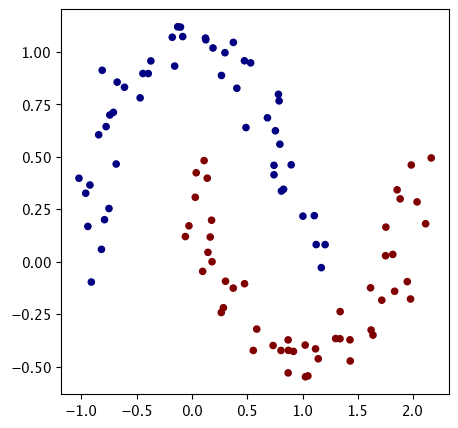

In [4]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [5]:
# initialize a model
model = MLP(2, [16, 16, 1])  # 2-layer neural network
print("number of parameters", len(model.parameters()))
print("data", X[0])
print("model", model.layers[0].neurons[0].parameters())

number of parameters 337
data [1.12211461 0.08147717]
model [Value(data=0.23550571390294128, grad=0), Value(data=0.06653114721000164, grad=0), Value(data=0, grad=0)]


In [6]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -y * score).relu() for y, score in zip(yb, scores)]

    data_loss = sum(losses) / len(losses)

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(y > 0) == (score.data > 0) for y, score in zip(yb, scores)]
    return total_loss, accuracy.count(True) / len(accuracy)


total_loss, accuracy = loss()
print(f"loss={total_loss.data} accuracy={accuracy}")

loss=0.8958441028683222 accuracy=0.5


In [7]:
data = [("Step", "Loss", "Accuracy")]

# optimization
for k in range(100):

    # forward
    total_loss, accuracy = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (Stochastic Gradient Descent)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    data.append((k, total_loss.data, accuracy))

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.742900631385113, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.28142343497724337, accuracy 89.0%
step 7 loss 0.26888733313983915, accuracy 91.0%
step 8 loss 0.2567147286057416, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.2450702385365804, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.21560951851922944, accuracy 91.0%
step 13 loss 0.23090378446402737, accuracy 93.0%
step 14 loss 0.20152151227899434, accuracy 92.0%
step 15 loss 0.2257450627928223, accuracy 93.0%
step 16 loss 0.19447987596204103, accuracy 92.0%
step 17 loss 0.2108949619924637, accuracy 93.0%
step 18 loss 0.15983077356303593, accuracy 94.0%
step 19 loss 0.1845374874688393, accuracy 93.0%
step 20 loss 0.18977522856087628, accuracy 

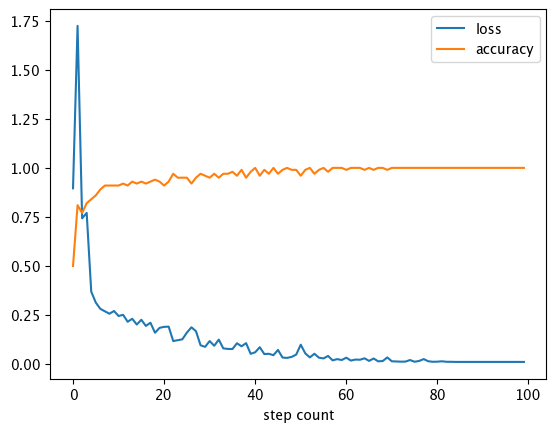

In [8]:
plt.plot([t[1] for t in data[1:]], label="loss")
plt.plot([t[2] for t in data[1:]], label="accuracy")

plt.xlabel("step count")
plt.legend()

plt.show()

(-1.548639298268643, 1.951360701731357)

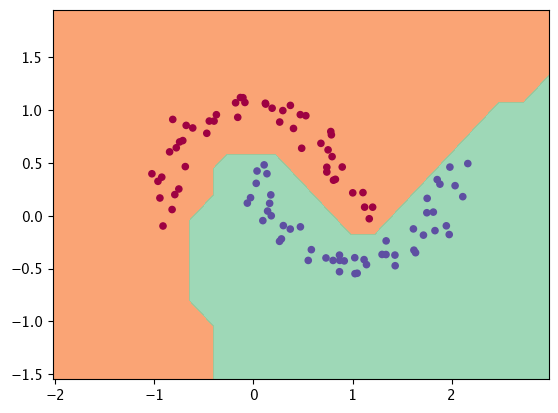

In [9]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())